In [ ]:
import pandas as pd
import numpy as np

from PIL import Image
import requests
from io import BytesIO

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt


#google collab drive mount
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
#from IPython.display import Image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/SF_Graffiti/Graffiti_cases_-_September_2017.csv'

# Read the dataset into a Pandas DataFrame

graf_image = pd.read_csv(file_path)

In [ ]:
#graf_image = pd.read_csv('Graffiti_cases_-_September_2017.csv')
graf_image.head()

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL
0,8030559,09/17/2017 05:58:00 PM,12/24/2019 11:08:08 AM,12/24/2019 11:08:08 AM,Closed,Case Resolved,DPW Ops Queue,Graffiti,Graffiti on Pole,Pole - Not_Offensive,Intersection of TWIN PEAKS BLVD and VILLA TER,8.0,Ashbury Heights,PARK,37.759937,-122.447150,"(37.75993667, -122.44715)",Mobile/Open311,http://mobile311.sfgov.org/reports/8030559/photos
1,8025888,09/16/2017 08:37:00 AM,NaN,03/11/2022 03:15:01 PM,Open,in progress,DPW Ops Queue,Graffiti,Graffiti on Other_enter_additional_details_below,Other_enter_additional_details_below - Offensive,"2091 MISSION ST, SAN FRANCISCO, CA, 94110",9.0,Mission,MISSION,37.763657,-122.419263,"(37.763657, -122.419263)",Mobile/Open311,http://mobile311.sfgov.org/reports/8025888/photos
2,8057534,09/23/2017 08:00:00 PM,09/24/2017 07:07:54 AM,09/24/2017 07:07:54 AM,Closed,Case Resolved - private building9/24/17 duplic...,DPW Ops Queue,Graffiti,Graffiti on Building_commercial,Building_commercial - Not_Offensive,Not associated with a specific address,NaN,NaN,NaN,0.000000,0.000000,"(0.0, 0.0)",Phone,NaN
3,7611589,09/08/2017 05:46:00 PM,09/13/2017 03:12:00 PM,09/13/2017 03:12:00 PM,Closed,Case is Invalid - Case is in Daly City. Not SF...,DPW Ops Queue,Graffiti,Graffiti on Signal_box,Signal_box - Not_Offensive,Not associated with a specific address,NaN,NaN,NaN,0.000000,0.000000,"(0.0, 0.0)",Phone,NaN
4,8069706,09/26/2017 10:30:00 PM,02/01/2018 02:50:00 PM,02/01/2018 02:50:00 PM,Closed,DPT Sign Shop - Other - Assigned,DPT SignShop 04 Queue,Graffiti,Graffiti on Sign,Sign - Not_Offensive,"3820 IRVING ST, SAN FRANCISCO, CA, 94122",4.0,Outer Sunset,TARAVAL,37.762689,-122.498732,"(37.76268859, -122.49873231)",Web,NaN


In [ ]:
graf_image['Request Details'].value_counts()
graf_image =  graf_image[graf_image['Request Details'].str.contains("Offensive", na = False)]
graf_image['Request Details'].value_counts()

Other_enter_additional_details_below - Offensive    770
Building_commercial - Not_Offensive                 521
Mail_box - Not_Offensive                            465
Pole - Not_Offensive                                371
Building_other - Not_Offensive                      342
Signal_box - Not_Offensive                          341
Transit_Shelter_Platform - Not_Offensive            259
Pole - Offensive                                    221
Sidewalk_in_front_of_property - Not_Offensive       210
Fire_hydrant - Not_Offensive                        171
Building_commercial - Offensive                     152
Sidewalk_in_front_of_property - Offensive           148
Parking_meter - Not_Offensive                       141
ATT_Property - Not_Offensive                        140
Building_residential - Not_Offensive                117
Signal_box - Offensive                              114
Sidewalk_structure - Not_Offensive                  113
City_receptacle - Not_Offensive                 

In [ ]:
#observe if the graffiti is offensive or not and add a column that deems it off/non-off
def offensive(series):
    if 'Not_Offensive' in series:
        return 'Not Offensive'
    else:
        return 'Offensive'



graf_image['grade'] = graf_image['Request Details'].apply(offensive)

In [ ]:
df = graf_image.dropna(subset=["Media URL", "grade"])
df

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL,grade
0,8030559,09/17/2017 05:58:00 PM,12/24/2019 11:08:08 AM,12/24/2019 11:08:08 AM,Closed,Case Resolved,DPW Ops Queue,Graffiti,Graffiti on Pole,Pole - Not_Offensive,Intersection of TWIN PEAKS BLVD and VILLA TER,8.0,Ashbury Heights,PARK,37.759937,-122.447150,"(37.75993667, -122.44715)",Mobile/Open311,http://mobile311.sfgov.org/reports/8030559/photos,Not Offensive
1,8025888,09/16/2017 08:37:00 AM,NaN,03/11/2022 03:15:01 PM,Open,in progress,DPW Ops Queue,Graffiti,Graffiti on Other_enter_additional_details_below,Other_enter_additional_details_below - Offensive,"2091 MISSION ST, SAN FRANCISCO, CA, 94110",9.0,Mission,MISSION,37.763657,-122.419263,"(37.763657, -122.419263)",Mobile/Open311,http://mobile311.sfgov.org/reports/8025888/photos,Offensive
5,8029370,09/17/2017 11:47:00 AM,05/20/2018 01:38:40 PM,05/20/2018 01:38:40 PM,Closed,Case Resolved - 9/22/17 posted,DPW Ops Queue,Graffiti,Graffiti on Building_commercial,Building_commercial - Not_Offensive,"901 16TH ST, SAN FRANCISCO, CA, 94107",10.0,Potrero Hill,SOUTHERN,37.766215,-122.395451,"(37.76621518, -122.39545074)",Mobile/Open311,http://mobile311.sfgov.org/reports/8029370/photos,Not Offensive
6,8059099,09/24/2017 01:21:00 PM,08/27/2018 11:19:19 AM,08/27/2018 11:19:19 AM,Closed,Case Resolved\nGraffiti removed,RPD Park Service Area 2 Queue,Graffiti,Graffiti on Other_enter_additional_details_below,Other_enter_additional_details_below - Offensive,Intersection of 20TH ST and INDIANA ST,10.0,Dogpatch,BAYVIEW,37.760446,-122.391215,"(37.76044567, -122.39121496)",Mobile/Open311,http://mobile311.sfgov.org/reports/8059099/photos,Offensive
7,8004845,09/11/2017 01:08:00 PM,01/11/2018 12:00:00 PM,01/11/2018 12:00:00 PM,Closed,Case Resolved,PUC - Water - Graffiti Queue,Graffiti,Graffiti on Fire_hydrant,Fire_hydrant - Offensive,"157 OCTAVIA ST, SAN FRANCISCO, CA, 94102",5.0,Lower Haight,NORTHERN,37.773725,-122.424163,"(37.77372528, -122.42416321)",Mobile/Open311,http://mobile311.sfgov.org/reports/8004845/photos,Offensive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,8083120,09/29/2017 10:28:00 PM,10/03/2017 06:48:30 AM,10/03/2017 06:48:30 AM,Closed,Case Resolved - SES Graffiti Crew - Paint - S...,DPW Ops Queue,Graffiti,Graffiti on Sidewalk_structure,Sidewalk_structure - Offensive,Intersection of GOUGH ST and MARKET ST,6.0,Lower Haight,SOUTHERN,37.772970,-122.422195,"(37.77297, -122.422195)",Mobile/Open311,http://mobile311.sfgov.org/reports/8083120/photos,Offensive
5566,8083122,09/29/2017 10:29:00 PM,09/29/2017 05:00:00 PM,09/29/2017 05:00:00 PM,Closed,Case is a Duplicate - Request is a duplicate a...,DPW Ops Queue,Graffiti,Graffiti on Pole,Pole - Not_Offensive,Intersection of MARKET ST and VALENCIA ST,6.0,Lower Haight,SOUTHERN,37.772688,-122.422592,"(37.77268833, -122.42259167)",Mobile/Open311,http://mobile311.sfgov.org/reports/8083122/photos,Not Offensive
5567,8083123,09/29/2017 10:29:00 PM,08/23/2018 11:00:26 AM,08/23/2018 11:00:26 AM,Closed,Case resolved. - Sign repaired or replaced.,DPT SignShop 05 Queue,Graffiti,Graffiti on Sign,Sign - Not_Offensive,Intersection of MARKET ST and VALENCIA ST,6.0,Lower Haight,SOUTHERN,37.772670,-122.422613,"(37.77267, -122.42261333)",Mobile/Open311,http://mobile311.sfgov.org/reports/8083123/photos,Not Offensive
5568,8083126,09/29/2017 10:31:00 PM,10/18/2017 05:00:00 PM,10/18/2017 05:00:00 PM,Closed,Case Resolved - 10/1/17 inspected property pos...,DPW Ops Queue,Graffiti,Graffiti on Building_commercial,Building_commercial - Offensive,"1740 MARKET ST, SAN FRANCISCO, CA, 94102",6.0,Lower Haight,SOUTHERN,37.772299,-122.423166,"(37.77229901, -122.42316553)",Mobile/Open311,http://mobile311.sfgov.org/reports/8083126/photos,Offensive


In [ ]:
subset = df.groupby('grade').apply(lambda x: x.head(80))

subset = subset.reset_index(drop=True)
subset = subset.sample(frac=1, random_state=42)

subset['grade'] = subset['grade'].replace({'Not Offensive': 0, 'Offensive': 1})
subset.grade.value_counts()

1    80
0    80
Name: grade, dtype: int64

## Image Preprocessing

In [ ]:
def preprocess_images(df, size):
  '''this function will retrieve the images from the media url column and turn it into np array'''
  images = []
  labels = []
  for index, row in df.iterrows():
      url = row['Media URL']
      label = row['grade']
      response = requests.get(url)
      img = Image.open(BytesIO(response.content))
      img = img.convert('RGB')  # convert all images to RGB format
      img = img.resize(size)
      img_array = np.array(img)
      images.append(img_array)
      labels.append(label)
  images = np.stack(images)
  labels = np.array(labels).flatten()
  return images, labels


In [ ]:
#read images from url, commented out if saved to csv already, check next cell
#images, labels = preprocess_images(subset, size=(112, 112))
#images_df = pd.DataFrame({'images': images.tolist()})
#labels_df = pd.DataFrame({'labels': labels.tolist()})


#np.save('/content/drive/MyDrive/SF_Graffiti/images.npy', images)
#np.save('/content/drive/MyDrive/SF_Graffiti/labels.npy', labels)


In [ ]:
loaded_images = np.load('/content/drive/MyDrive/SF_Graffiti/images.npy')
loaded_labels = np.load('/content/drive/MyDrive/SF_Graffiti/labels.npy')
images= loaded_images
labels = loaded_labels

In [ ]:
#images= pd.read_csv('/content/drive/MyDrive/SF_Graffiti/images.csv')
#labels = pd.read_csv('/content/drive/MyDrive/SF_Graffiti/labels.csv')

print(images.shape)
print(labels.shape)

(160, 112, 112, 3)
(160,)


In [ ]:
IMAGE_SIZE = (112, 112)
CONTRAST_FACTOR = 3
DELTA = 0.3
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(labels, [splits[0], splits[0]+splits[1]])

    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)

    # rescale image to [0,1], i.e., greyscale
    X_train = tf.image.rgb_to_grayscale(X_train)/255.0
    X_val = tf.image.rgb_to_grayscale(X_val)/255.0
    X_test = tf.image.rgb_to_grayscale(X_test)/255.0


    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)

    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)

    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images,
    labels,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 112, 112, 1)
y_train shape (192,)
X_val shape (32, 112, 112, 1)
y_val shape (32,)
X_test shape (32, 112, 112, 1)
y_test shape (32,)


Print training data examples:


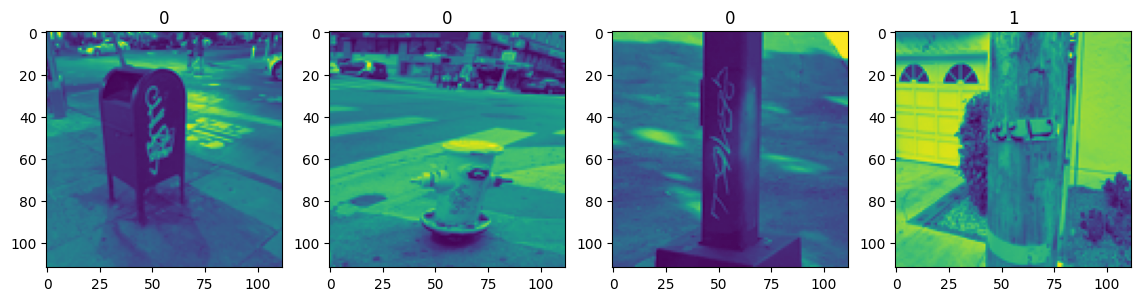

In [ ]:
#train images
print('Print training data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])

Print validation data examples:


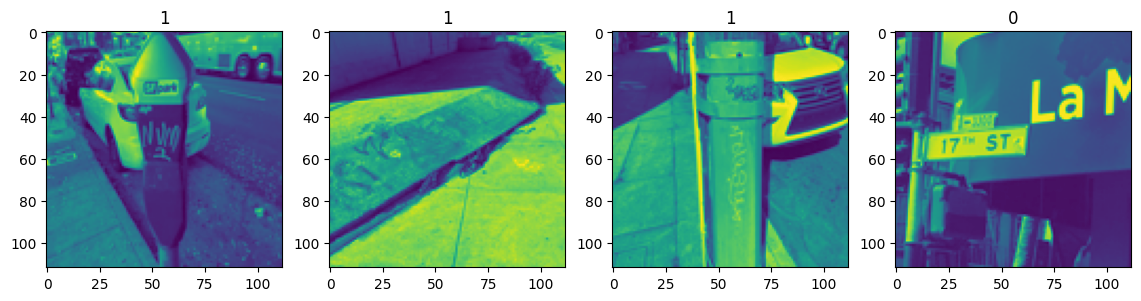

In [ ]:
#test images
print('Print validation data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_val[i]))
    axs[i].set(title=y_val[i])

In [ ]:
#take a look at the labels
y_train

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0])

## FFNN

In [ ]:
def train_test_ffnn_model(input_shape,
                        activation = 'relu',
                          dropout = 0.3,
                          learning_rate = .0001,
                          patience = 15):
  '''Train and test a ffnn model with these hyperparameters'''


  early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
  #build and fit model
  ffnn_model = build_ffnn(input_shape, activation = activation, dropout = dropout)

  history_ffnn = ffnn_model.fit(X_train, y_train, epochs=100, batch_size = 16, validation_data=(X_val, y_val),callbacks=[early_stopping])
  epochs_before_early_stopping = early_stopping.stopped_epoch + 1

  #extract and plot accuracies
  last_epoch_train_accuracy = history_ffnn.history['accuracy'][-1]
  last_epoch_val_accuracy = history_ffnn.history['val_accuracy'][-1]
  plot_training_history(history_ffnn)

  test_loss, test_accuracy = ffnn_model.evaluate(X_test, y_test)
  print("Test Loss:", test_loss)
  print("Test Accuracy:", test_accuracy)

  add_hyperp(input_shape,epochs_before_early_stopping, activation, dropout, learning_rate, last_epoch_train_accuracy, last_epoch_val_accuracy, test_accuracy)



In [ ]:
hyperp_df = pd.DataFrame(columns = ['input_shape', 'num_epochs', 'activation', 'dropout', 'learning_rate', 'train_accuracy', 'val_accuracy', 'test_accuracy'])

In [ ]:
def add_hyperp(*hypers):
  '''add hyper parameters to a table '''
  hyperp_df.loc[len(hyperp_df)] = hypers

In [ ]:
def plot_training_history(history):
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    ax.set_ylim(0, 1)

    plt.show()

# Assuming history_ffnn is the training history object


In [ ]:
def build_ffnn(input_shape, activation = 'relu',dropout = 0.3, learning_rate = .0001):
    '''input shape: example(224,224,1)'''

    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    input_layer = tf.keras.layers.Input(shape=input_shape, name='Input')
    flatten_layer = tf.keras.layers.Flatten(name='Flatten')(input_layer)



    activation_layer = 'relu'
    if activation == 'leaky_relu':
        activation_layer = tf.keras.layers.LeakyReLU(alpha=0.2, name='LeakyReLU')
    elif activation == 'elu':
        activation_layer = tf.keras.layers.ELU(alpha=1.0, name='ELU')

    fc1_layer = tf.keras.layers.Dense(units=12544, activation=activation_layer, name='fc_1')(flatten_layer)
    fc2_layer = tf.keras.layers.Dense(units=3136, activation=activation_layer, name='fc_2')(fc1_layer)

    dropout_layer = tf.keras.layers.Dropout(rate=dropout, name='Dropout')(fc2_layer)

    output_layer = tf.keras.layers.Dense(units=1, activation=None, name='fc_4')(dropout_layer)


    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return model

In [ ]:

#device = cuda.get_current_device()
#device.reset()
from keras import backend as K
K.clear_session()
tf.keras.backend.clear_session()

Epoch 1/100
12/12 [==============================] - 4s 213ms/step - loss: 3.4885 - accuracy: 0.5312 - val_loss: 1.5736 - val_accuracy: 0.4688
Epoch 2/100
12/12 [==============================] - 1s 128ms/step - loss: 1.1493 - accuracy: 0.5938 - val_loss: 0.8125 - val_accuracy: 0.5312
Epoch 3/100
12/12 [==============================] - 0s 41ms/step - loss: 0.7707 - accuracy: 0.6146 - val_loss: 0.8154 - val_accuracy: 0.5312
Epoch 4/100
12/12 [==============================] - 1s 121ms/step - loss: 0.6247 - accuracy: 0.6927 - val_loss: 0.7070 - val_accuracy: 0.5938
Epoch 5/100
12/12 [==============================] - 0s 39ms/step - loss: 0.4745 - accuracy: 0.7969 - val_loss: 0.8713 - val_accuracy: 0.5938
Epoch 6/100
12/12 [==============================] - 0s 38ms/step - loss: 0.4664 - accuracy: 0.7812 - val_loss: 1.0127 - val_accuracy: 0.5312
Epoch 7/100
12/12 [==============================] - 0s 39ms/step - loss: 0.4539 - accuracy: 0.7865 - val_loss: 0.8496 - val_accuracy: 0.5625
Epo

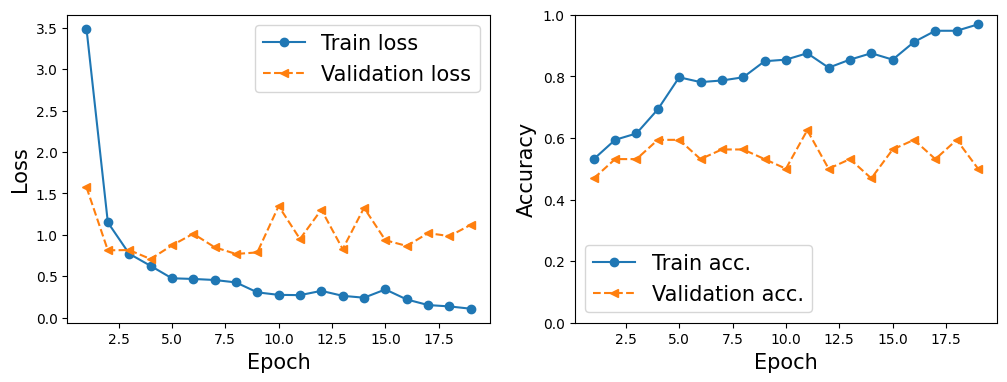

1/1 [==============================] - 0s 126ms/step - loss: 0.7751 - accuracy: 0.5312
Test Loss: 0.7750557661056519
Test Accuracy: 0.53125


11289

In [ ]:
 #tested hyperprameters
 #activation = relu, leaky relu, elu
 #dropout = 0.3, 0.5
 #learning_rate = .001, .0001

train_test_ffnn_model((112,112,1), activation = 'relu', dropout = 0.3, learning_rate= .001, patience = 15)
import gc
gc.collect()

In [ ]:
hyperp_df

,input_shape,num_epochs,activation,dropout,learning_rate,train_accuracy,val_accuracy,test_accuracy
0,"(112, 112, 1)",19,leaky_relu,0.3,0.0001,0.901042,0.56250,0.53125
1,"(112, 112, 1)",19,relu,0.3,0.0001,0.963542,0.56250,0.50000
2,"(112, 112, 1)",19,elu,0.3,0.0001,0.848958,0.53125,0.56250
3,"(112, 112, 1)",17,relu,0.5,0.0001,0.901042,0.56250,0.53125
4,"(112, 112, 1)",28,leaky_relu,0.5,0.0001,0.880208,0.53125,0.43750
5,"(112, 112, 1)",22,elu,0.5,0.0001,0.901042,0.50000,0.50000
6,"(112, 112, 1)",20,relu,0.3,0.0010,0.958333,0.56250,0.43750
7,"(112, 112, 1)",22,leaky_relu,0.3,0.0010,0.890625,0.53125,0.56250
8,"(112, 112, 1)",20,elu,0.3,0.0010,0.953125,0.53125,0.56250
9,"(112, 112, 1)",20,elu,0.5,0.0010,0.864583,0.56250,0.46875


In [ ]:
#save hyperp_df to csv
hyperp_df.to_csv('FFNN_hyperparameters.csv', index = 'False')

# CNN

In [ ]:
def train_test_cnn_model(input_shape,
                        activation = 'relu',
                          dropout = 0.3,
                          learning_rate = .0001,
                         stride = (1,1),
                     kernel_size = (3,3),
                     pool_size = (2,2),
                          patience = 15):
  '''Train and test a ffnn model with these hyperparameters'''


  early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
  #build and fit model
  cnn_model = build_custom_cnn(input_shape, activation = activation, dropout = dropout)

  history_cnn = cnn_model.fit(X_train, y_train, epochs=100, batch_size = 16, validation_data=(X_val, y_val),callbacks=[early_stopping])
  epochs_before_early_stopping = early_stopping.stopped_epoch + 1

  #extract and plot accuracies
  last_epoch_train_accuracy = history_cnn.history['accuracy'][-1]
  last_epoch_val_accuracy = history_cnn.history['val_accuracy'][-1]
  plot_training_history(history_cnn)

  test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
  print("Test Loss:", test_loss)
  print("Test Accuracy:", test_accuracy)

  add_cnn_hyperp(input_shape, epochs_before_early_stopping, activation, dropout, learning_rate, stride, kernel_size, pool_size, last_epoch_train_accuracy, last_epoch_val_accuracy, test_accuracy)



In [ ]:
hyperp_cnn_df = pd.DataFrame(columns = ['input_shape', 'num_epochs', 'activation', 'dropout', 'learning_rate', 'stride', 'kernel_size', 'pool_size', 'train_accuracy', 'val_accuracy', 'test_accuracy'])

In [ ]:
def add_cnn_hyperp(*hypers):
  '''add hyper parameters to a table '''
  hyperp_cnn_df.loc[len(hyperp_df)] = hypers

In [ ]:
def build_custom_cnn(input_shape = (112, 112, 1),  dropout = .3, learning_rate = .001,
                     stride = (1,1),
                     kernel_size = (3,3),
                     pool_size = (2,2),
                     activation = 'relu'):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_size,
        strides=stride,
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation=activation))

    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_size,
        name='pool_1'))

    model.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=kernel_size,
        strides=stride,
        padding='same',
        name='conv_2',
        activation=activation))

    model.add(tf.keras.layers.MaxPool2D(
        pool_size=pool_size,
        name='pool_2'))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=1024,
        name='fc_1',
        activation=activation))

    model.add(tf.keras.layers.Dropout(rate=dropout))

    model.add(tf.keras.layers.Dense(
        units=1,
        name='fc_2',
        activation=None))

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model


Epoch 1/100
12/12 [==============================] - 2s 75ms/step - loss: 2.4249 - accuracy: 0.5312 - val_loss: 0.6753 - val_accuracy: 0.5312
Epoch 2/100
12/12 [==============================] - 0s 20ms/step - loss: 0.6757 - accuracy: 0.5208 - val_loss: 0.6920 - val_accuracy: 0.5312
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 0.6200 - accuracy: 0.5260 - val_loss: 0.6968 - val_accuracy: 0.5312
Epoch 4/100
12/12 [==============================] - 0s 18ms/step - loss: 0.4702 - accuracy: 0.7188 - val_loss: 0.7019 - val_accuracy: 0.5938
Epoch 5/100
12/12 [==============================] - 0s 18ms/step - loss: 0.3523 - accuracy: 0.8177 - val_loss: 0.7246 - val_accuracy: 0.5312
Epoch 6/100
12/12 [==============================] - 0s 19ms/step - loss: 0.2607 - accuracy: 0.8854 - val_loss: 0.9108 - val_accuracy: 0.5312
Epoch 7/100
12/12 [==============================] - 0s 20ms/step - loss: 0.2307 - accuracy: 0.9010 - val_loss: 0.7580 - val_accuracy: 0.4375
Epoch 

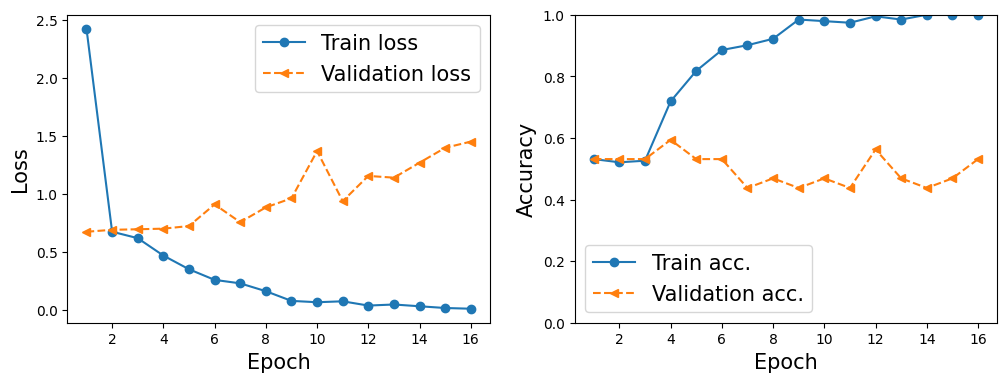

1/1 [==============================] - 0s 172ms/step - loss: 0.7122 - accuracy: 0.4375
Test Loss: 0.7121952176094055
Test Accuracy: 0.4375


In [ ]:
train_test_cnn_model(input_shape = (112, 112,1),
    activation = 'relu',
                      dropout = 0.5,
                      learning_rate = .001,
                     stride = (2,2),
                     kernel_size = (3,3),
                     pool_size = (2,2),
                      patience = 15)

In [ ]:
hyperp_cnn_df

,input_shape,num_epochs,activation,dropout,learning_rate,stride,kernel_size,pool_size,train_accuracy,val_accuracy,test_accuracy
13,"(112, 112, 1)",16,relu,0.5,0.001,"(2, 2)","(3, 3)","(2, 2)",1.0,0.53125,0.4375
